# CS640 Programming Assignment 1: Neural Network

In this programming assignment, you are asked to construct a neural network model (almost) from scratch, run experiments, and write reports. We provide a script of skeleton code as well as three datasets.

Your tasks are the following.
1. Build your network model following the instruction.
2. Run experiments and produce results.
3. Interpret and discuss your results.

## Submission
Everything you need to complete for this assignment is in this notebook, so this file is the only thing to submit via Gradescope before the deadline.

## Collaboration
You are allowed to work in a team of at most **three** on the **Q1: Coding** part, but you must run the experiments and write the reports independently.

## More instructions

If you are new to Python or its scientific library, Numpy, there are some nice tutorials [here](https://www.learnpython.org/) and [here](http://www.scipy-lectures.org/).

In an ipython notebook, to run code in a cell or to render [Markdown](https://en.wikipedia.org/wiki/Markdown)+[LaTeX](https://en.wikipedia.org/wiki/LaTeX) press `Ctrl+Enter` or `[>|]`(like "play") button above. To edit any code or text cell (double) click on its content. To change cell type, choose "Markdown" or "Code" in the drop-down menu above.

To enter your solutions for the written questions, put down your derivations into the corresponding cells below using LaTeX. Show all steps when proving statements. If you are not familiar with LaTeX, you should look at some tutorials and at the examples listed below between \$..\$. We will not accept handwritten solutions.

Put your solutions into boxes marked with **`[double click here to add a solution]`** and press Ctrl+Enter to render text. (Double) click on a cell to edit or to see its source code. You can add cells via **`+`** sign at the top left corner.

**Q0: What's your name? If you are collaborating with someone, please list their names here as well.**

**Lingyan Jiang**

**Q1: Coding**

**Q1.1: Import Packages**

The packages that have been imported in the following block should be sufficient for this assignment, but you are free to add more if necessary. However, keep in mind that you **should not** import and use any neural network package. If you have concern about an addition package, please contact us via Piazza.

In [46]:
import numpy as np
import scipy as sp
import os, sys
from sklearn.model_selection import StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import math

**Q1.2: Load Data**

We provide two sets of data, namely dataset1 and dataset2. Dataset1 contains two subsets of data, namely linearly and nonlinearly, neither of which is splitted into training and testing; while dataset2 has been splitted into training and testing. Write functions here to load them in your favorable way. You may want to skip this part first and come back after reading the experimenting part below.

In [47]:
def getDataset1(dataDir, is_linear = True):
    if is_linear:
        samples = pd.read_csv(dataDir + 'LinearX.csv', index_col=False, header=None)
        X = samples.values
        label = pd.read_csv(dataDir + 'LinearY.csv', index_col=False, header=None)
        Y = label.values
    else:
        samples = pd.read_csv(dataDir + 'NonlinearX.csv', index_col=False, header=None)
        X = samples.values
        label = pd.read_csv(dataDir + 'NonlinearY.csv', index_col=False, header=None)
        Y = label.values
    return X, Y

def getDataset2(dataDir):
    samples = pd.read_csv(dataDir + 'Digit_X_train.csv', index_col=False, header=None)
    XTrain = samples.values
    label = pd.read_csv(dataDir + 'Digit_y_train.csv', index_col=False, header=None)
    YTrain = label.values.astype(np.int64)
    realx = pd.read_csv(dataDir + 'Digit_X_test.csv', index_col=False, header=None)
    XTest = realx.values
    realy = pd.read_csv(dataDir + 'Digit_y_test.csv', index_col=False, header=None)
    YTest = realy.values.astype(np.int64)
    return XTrain, YTrain, XTest, YTest
    

**Q1.3: Define Activation and Loss Functions**

Complete the following functions. The ones starting with a "d" is the derivative of the corresponding function. You are free to implement additional ones (for example, softmax and cross-entory loss) if interested.

In [48]:
def sigmoid(x):
    sigmoidx = 1/(1 + np.exp(-x))
    return sigmoidx
    
def dSigmoid(x):
    return x*(1.0-x)
    
def euclideanLoss(YTrue, YPredict):
    YTrue = np.array(YTrue)
    YPredict = np.array(YPredict)
    loss = 0
    for i in range(len(YTrue)):
        sum = 0.5 * np.square(YPredict[i] - YTrue[i])
        loss = loss + sum 
    return loss
    
def dEuclideanLoss(YTrue, YPredict):
    YTrue = np.array(YTrue)
    YPredict = np.array(YPredict)
    loss =YPredict - YTrue
    return loss

In [49]:
#test
a = [3,4,6,5]
b = [4,5,6,4]
print(euclideanLoss(a,b))
print(dEuclideanLoss(a, b))

1.5
[ 1  1  0 -1]


**Q1.4: Define the Layer Class**

Complete the ***initializeWeights*** function, which initializes the weights and biases with small random values. The ***\_\_init\_\_*** function should be left as it is, though you are free to modify if you like.

In [50]:
class Layer:
    def __init__(self, NInput, NOutput, bias = True):
        self.NInput = NInput
        self.NOutput = NOutput
        self.useBias = bias
        self.initializeWeights()
    
    def initializeWeights(self):
        #Initializes the weights and biases with small random values.
        self.weights = np.random.randn(self.NInput, self.NOutput) / np.sqrt(self.NInput)  
        self.bias = np.zeros((1, self.NOutput))

**Q1.5: Define the Network Class**

This is the heaviest part of this assignment. We recommend you to first go over the math carefully before starting this part.

In addition, you are strongly encouraged to use numpy for matrix operations. When doing multiplication, please be careful about the dimensions, as well as the difference between the "*" operator, numpy's ***multiply*** function, and numpy's ***dot*** function.

In [134]:
class Network:
    def __init__(self, layers, activationList, dActivationList, loss, dLoss):
        """
        Parameters
        ----------
        layers : List[Layers]
            This should be a list of Layers objects.
        activationList/dActivationList: List[functions]
            This should be a list of activation/derivative functions (e.g. sigmoid/dSigmoid).
        loss/dLoss: function
            This should be a loss/derivative function (e.g. enclideanLoss/dEuclideanLoss).
        """
        assert len(layers) == len(activationList) == len(dActivationList)
        self.layers = layers
        self.activationList = activationList
        self.dActivationList = dActivationList
        self.loss = loss
        self.dLoss = dLoss
    
                
    def fit(self, X, Y, learningRate, regLambda):
        """
        Fit the model with input features and targets.
        Parameters
        ----------
        X, Y : array-like
            X contains the input features while Y contains the target values.
        learningRate, regLambda : float
            Basic hyperparameters for the model.
        """
        # First, initialize zero gradients.
        
        # Next, use the forward and backprog functions to accumulate gradients
        # sample by sample.
        # Hint:
        # For each sample, do:
        #     Forward pass once, using the forward function defined below.
        #     Backward propagation, using the backprog function defined below.
        
        # Lastly, update weights and biases using the gradients; don't forget to
        # take the mean before updating the weights. Note that both the learning
        # rate and the regularization should appear here.

            
        dweight=[]
        dbias=[]
        dweight.clear()
        dbias.clear()
        for layer in self.layers[::-1]:
            dweight.append(np.zeros_like(layer.weights))
            dbias.append(np.zeros_like(layer.bias))
        value = self.forward(X)
        dbias, dweight = self.backprog(value, X, Y, dbias, dweight)
        num_sample = X.shape[0]
        c = learningRate / num_sample
        for rev_i, layer in enumerate(self.layers[::-1]):
            layer.bias -= c * dbias[rev_i]
            layer.weights =  (1 - c * regLambda) * layer.weights - c * dweight[rev_i] 
            
  

    def predict(self,X):
        for layer in self.layers:
            if layer == self.layers[-1]:
                X = np.dot(X,layer.weights) + layer.bias
            else:
                z1 = np.dot(X,layer.weights) + layer.bias
                X = np.tanh(z1)       
        exp_z2 = np.exp(X)
        softmax_scores = exp_z2 / np.sum(exp_z2, axis=1, keepdims=True)
        predictions = np.argmax(softmax_scores, axis = 1)
        return predictions
    
    
    
    
    def forward(self, X):
        value=[X]
        for layer in self.layers:
            if layer == self.layers[-1]:
                X = np.dot(X,layer.weights) + layer.bias
            else:
                z1 = np.dot(X,layer.weights) + layer.bias
                X = np.tanh(z1) 
                value.append(X)
        exp_z2 = np.exp(X)
        softmax_scores = exp_z2 / np.sum(exp_z2, axis=1, keepdims=True)
        value.append(softmax_scores)
        return value
    
########       
    def backprog(self, value, X, Y, dbias, dweight):
        softmax_scores=value[-1]
        value_del=value[0:-1][::-1]
        one_hot_y = np.zeros_like(softmax_scores)
        for i in range(X.shape[0]):
            one_hot_y[i, Y[i]] = 1
        for index, layer in enumerate(self.layers[::-1]): 
            if layer == self.layers[-1]:
                beta = softmax_scores - one_hot_y
            else:
                layerList=self.layers[::-1]
                next_layer=layerList[index-1]
                beta = np.dot(beta, next_layer.weights.T) * (1 - np.power(value_del[index-1], 2))
            dbias[index] = np.sum(beta, axis  = 0, keepdims=True)
            dweight[index] = np.dot(value_del[index].T, beta)
        return dbias, dweight
          
    
    def getLoss(self, X, Y):
        num_examples = np.shape(X)[0]
        value = self.forward(X)
        softmax_scores = value[-1]
        one_hot_y = np.zeros((num_examples,np.max(Y)+1))
        logloss = np.zeros((num_examples))        
        for i in range(np.shape(X)[0]):
            one_hot_y[i,Y[i]] = 1
            logloss[i] = -np.sum(np.log(softmax_scores[i,:]) * one_hot_y[i,:])
        data_loss = np.sum(logloss)
        return 1./num_examples * data_loss

**Q1.6: Define Evaluation Functions**

Complete the functions below following the instructions in the comments. **Do not** use an existing library. If you would like to include a ROC analysis in your report, please add the corresponding function in this section.

In [135]:
def getConfusionMatrix(YTrue, YPredict):
    """
    Computes the confusion matrix.
    Parameters
    ----------
    YTrue : numpy array
        This array contains the ground truth.
    YPredict : numpy array
        This array contains the predictions.
    Returns
    CM : numpy matrix
        The confusion matrix.
    """
    acc = 0
    con_mat = np.zeros((10,10))
    for i in range(len(YPredict)):
        con_mat[YPredict[i], YTrue[i]] += 1
        if YTrue[i] == YPredict[i]: 
            acc += 1
    acc = acc*1.0/len(YPredict)
    
    return acc, con_mat

    

    
def getPerformanceScores(YTrue, YPredict):
    """
    Computes the accuracy, precision, recall, f1 score.
    Parameters
    ----------
    YTrue : numpy array
        This array contains the ground truth.
    YPredict : numpy array
        This array contains the predictions.
    Returns
    {"CM" : numpy matrix,
    "accuracy" : float,
    "precision" : float,
    "recall" : float,
    "f1" : float}
        This should be a dictionary.
    """
    YTrue = YTrue.T.flatten()
    YPredict = YPredict.T.flatten()
    true = 0
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(YTrue)):
        if YTrue[i] == YPredict[i]:
            true = true + 1;
    print("accuracy is ")
    print(true / len(YTrue))
    #accuracy = (CM[0][0] + CM[1][1]) / (CM[0][0] + CM[0][1] + CM[1][0] + CM[1][1])
    #precision = (CM[0][0]) / (CM[1][0] + CM[0][0])
    #recall = CM[0][0] / (CM[0][0] + CM[0][1])
    #f1 = 2 / (1 / precision + 1 / recall)
    #return CM, accuracy, precision, recall, f1
   

**Q1.7: Test Model**

Use the following example code to test your model with some simple data. You may want to go back to **Q1.2** if you skipped it earlier.

Hint:
1. Changing your model structure can help you discover bugs in implementation.
2. The loss plot should help you make sure that your model is indeed learning.

**You need to produce decreasing loss curves here.**

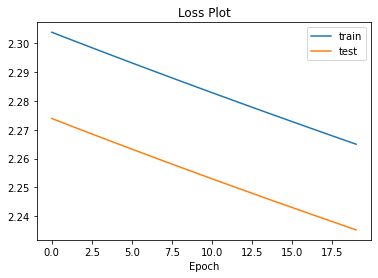

In [136]:
XTrain, YTrain, XTest, YTest = getDataset2('/Users/lingyanjiang/study/cs640/P1/Data/dataset2/')# change this line accordingly

# assemble your model
layers = [Layer(64, 10), Layer(10, 10)]
model = Network(layers, [sigmoid, sigmoid], [dSigmoid, dSigmoid], euclideanLoss, dEuclideanLoss)

# specify training parameters
epochs = 20
learningRate = 1e-2
regLambda = 0

# capture the loss values during training
loss = {"train" : [0.0] * epochs, "test" : [0.0] * epochs}

# start training
for epoch in range(epochs):
    model.fit(XTrain, YTrain, learningRate, regLambda)
    loss["train"][epoch] = model.getLoss(XTrain, YTrain)
    loss["test"][epoch] = model.getLoss(XTest, YTest)

# plot the losses, both curves should be decreasing
plt.plot([i for i in range(epochs)], loss["train"], label = "train")
plt.plot([i for i in range(epochs)], loss["test"], label = "test")
plt.legend()
plt.title("Loss Plot")
plt.xlabel("Epoch")
plt.show()


**Q2: Experimenting with Dataset 1**

In this section, the **performance results** you need to report include the following:
1. confusion matrix;
2. accuracy;
3. precision;
4. recall;
5. F1 score.

**Q2.1: LinearXY**

Split the data using [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Train your model, evaluate the prediction on the testing subset, and report the **performance results**.

In [148]:
# write your code in this block
XTrain, YTrain, XTest, YTest = getDataset2('/Users/lingyanjiang/study/cs640/P1/Data/dataset2/')# change this line accordingly

# assemble your model
layers = [Layer(64, 10), Layer(10, 10)]
model = Network(layers, [sigmoid, sigmoid], [dSigmoid, dSigmoid], euclideanLoss, dEuclideanLoss)

# specify training parameters
epochs = 20
learningRate = 1e-2
regLambda = 0

# start training
for epoch in range(epochs):
    model.fit(XTrain, YTrain, learningRate, regLambda)
    
#test
YPredict = model.predict(XTest)
YPredict = YPredict
#print(YPredict)
#print(YTest)
  

print(getConfusionMatrix(YTest, YPredict))
#print(getPerformanceScores(YTest, YPredict))

(0.3047830923248053, array([[62.,  0.,  9.,  2.,  6.,  5.,  7.,  3.,  5.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0., 17.,  0.,  0.,  0.],
       [ 9., 15., 42., 12., 34., 15.,  4., 38., 42., 38.],
       [ 0.,  2.,  3., 30.,  0.,  2.,  0.,  0.,  0.,  2.],
       [ 8.,  0.,  1.,  0., 30.,  1., 59.,  0.,  1.,  0.],
       [ 3.,  2.,  7.,  7.,  7., 64.,  2.,  0.,  3.,  2.],
       [ 0., 50.,  0.,  0.,  4.,  0.,  2.,  1., 12.,  0.],
       [ 0., 22., 24., 39.,  5.,  1.,  0., 43., 24., 50.],
       [ 5.,  0.,  0.,  0.,  6.,  3.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  4.,  0.,  0.]]))


In addition, use the provided ***plotDecisionBoundary*** function to visualize the data.

In [145]:
def plotDecisionBoundary(model, X, Y):
    """
    Plot the decision boundary given by model.
    Parameters
    ----------
    model : model, whose parameters are used to plot the decision boundary.
    X : input data
    Y : input labels
    """
    x1_array, x2_array = np.meshgrid(np.arange(-4, 4, 0.01), np.arange(-4, 4, 0.01))
    grid_coordinates = np.c_[x1_array.ravel(), x2_array.ravel()]
    Z = model.predict(grid_coordinates)
    #threshold = 0.5
    #for i in range (Z.shape[0]):
        #if Z[i] >= threshold:
            #Z[i] = 1
        #elif Z[i] < threshold:
            #Z[i] = 0
    Z = Z.reshape(x1_array.shape)
    plt.contourf(x1_array, x2_array, Z, cmap=plt.cm.bwr)
    plt.scatter(X[:, 0], X[:, 1], c='y', cmap=plt.cm.bwr)
    plt.show()


In [147]:
plotDecisionBoundary(model, XTrain, YTrain)

ValueError: shapes (640000,2) and (64,10) not aligned: 2 (dim 1) != 64 (dim 0)

**Q2.2: NonLinearXY**

For the experiments done in this subset of the data, apply stratified 5-fold cross-validation (use the [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) module from scikit-learn), and report the mean **performance results** across the folds.

You should produce and describe in words
1. **performance results** of at least **5** different choices of total epochs;
2. **performance results** of at least **5** different choices of learning rate;
3. **performance results** of at least **3** different choices of regularization parameter.

**Q3: Experimenting with Dataset 2**

Train your model, evaluate the prediction on the testing subset, report and describe in words
1. **performance results** of at least **5** different choices of total epochs;
2. **performance results** of at least **5** different choices of learning rate;
3. **performance results** of at least **3** different choices of regularization parameter.
4. **performance results** of at least **5** different choices of number of nodes in the hidden layer.

**Q4: Other Questions**

**Q4.1** Briefly describe the workflow of how your model classify the data.

**`[double click here to add a solution]`**

**Q4.2** In your own words, explain how the forward propagation in your model works. You can cite your code here.

**`[double click here to add a solution]`**

**Q4.3** In your own words, explain how the backward propagation in your model works. You can cite your code here.

**`[double click here to add a solution]`**

**Q4.4** In theory, how do the total number of epochs, the learning rate, and the regularization parameter impact the performance of model? Does any of the theoretical impact actually happen in your result? If so, point them out.